<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Строится модель для такого предсказания.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.core.display import HTML

from catboost import CatBoostRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
try:
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

## Подготовка

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.describe(include='all')

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Качество данных хорошее, без пропусков, переходим к подготовке временного ряда

In [6]:
## ресемплирование по часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

### Тренды и стационарность

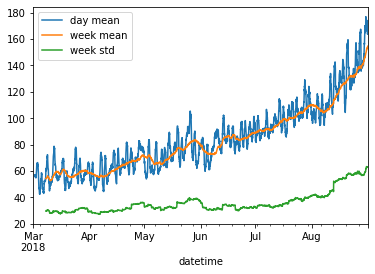

In [7]:
data['num_orders'].rolling(24).mean().plot(label='day mean');
data['num_orders'].rolling(24 * 7).mean().plot(label='week mean');
data['num_orders'].rolling(24 * 7).std().plot(label='week std');
plt.title('Среднее и стандартное отклонение');
plt.legend();

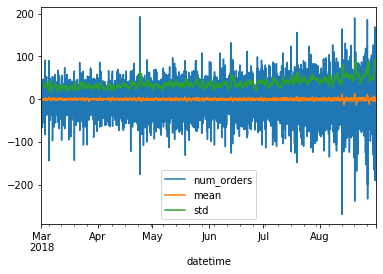

In [8]:
## анализ разностей первого порядка
df = data - data.shift()
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
plt.title('Среднее и стандартное отклонение разностей первого порядка');
df.plot();

In [9]:
## анализ стационарности
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


### Тренды и сезонность

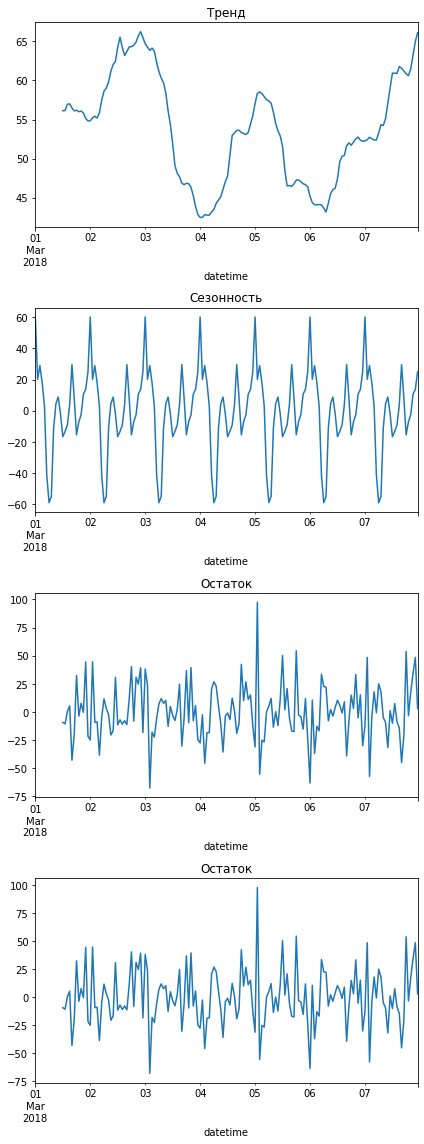

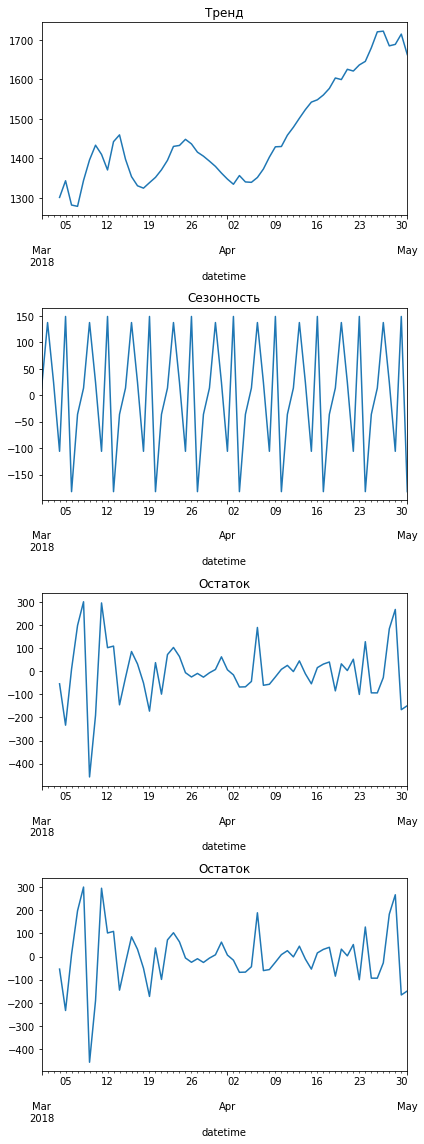

In [11]:
def draw_seasonal_decompose(period: str, t_to: str):
    display(HTML(f'<h3>Сезонность для квантования: {period}</h3>'))
    decomposed = seasonal_decompose(data.resample(period).sum())
    plt.figure(figsize=(6, 16))

    plt.subplot(4, 1, 1)
    decomposed.trend[:t_to].plot(ax=plt.gca())
    plt.title('Тренд')

    plt.subplot(4, 1, 2)
    decomposed.seasonal[:t_to].plot(ax=plt.gca())
    plt.title('Сезонность')

    plt.subplot(4, 1, 3)
    decomposed.resid[:t_to].plot(ax=plt.gca())
    plt.title('Остаток')

    plt.subplot(4, 1, 4)
    decomposed.resid[:t_to].plot(ax=plt.gca())
    plt.title('Остаток')

    plt.tight_layout()
    plt.show()

##2018-03-01 00:00:00 to 2018-08-31 23:00:00
for period, t_to in zip(['1H','1D'],['2018-03-07','2018-05-01']):
    draw_seasonal_decompose(period, t_to)

### Выводы
В заказах наблюдается возрастающий тренд, недельная и дневная сезонности
Автоматически получить информацию о сезонности в рамках более крупных временных интервалов (месяц, год),  не представляется возможным ввиду малого количества данных



## Обучение Модели

In [12]:
## константы для обучения
RANDOM_STATE = 150782
TEST_SIZE = 0.10
CV_BLOCK_COUNT = 5

CV_SCORRING = 'neg_root_mean_squared_error'

In [13]:
## функция для подготовки дополнительных признаков
def make_featured_df(df, max_lag=None, rolling_mean_size=None):
    df_res = df.copy()
    df_res['dayofweek'] = df_res.index.dayofweek
    df_res['day'] = df_res.index.day
    df_res['hour'] = df_res.index.hour

    if max_lag > 0:
        for lag in range(1, max_lag + 1):
            df_res['lag_{}'.format(lag)] = df_res['num_orders'].shift(lag)
    if rolling_mean_size > 0:
        df_res['rolling_mean'] = df_res['num_orders'].shift().rolling(rolling_mean_size).mean()

    df_res.dropna(inplace=True)
    return df_res

In [14]:
def train_and_test(model, features, target):
    tscv = TimeSeriesSplit(n_splits=CV_BLOCK_COUNT)
    rmse = cross_val_score(model,
                           features, target,
                           scoring=CV_SCORRING,
                           cv=tscv, n_jobs=-1).mean()
    return rmse

In [15]:
def calculate_dummy_baseline():
    print('baseline для адекватности будущих моделей')
    train_data, test_data = train_test_split(data, test_size=TEST_SIZE, shuffle=False)
    print(f'train min={train_data.index.min()} max={train_data.index.max()}')
    print(f'train min={test_data.index.min()} max={test_data.index.max()}')

    print("Средние количество заказов в час час:", test_data['num_orders'].mean())
    pred_median = np.ones(test_data.shape) * train_data['num_orders'].median()
    pred_prev = test_data.shift(fill_value=train_data['num_orders'].iloc[-1])
    print("rmse median:", mean_squared_error(test_data, pred_median, squared=False))
    print("rmse previous:", mean_squared_error(test_data, pred_prev, squared=False))


calculate_dummy_baseline()

train min=2018-03-01 00:00:00 max=2018-08-13 13:00:00
train min=2018-08-13 14:00:00 max=2018-08-31 23:00:00
Средние количество заказов в час час: 139.55656108597285
rmse median: 87.15277582981295
rmse previous: 58.856486242815066


In [16]:
## модели для обучения
models = [
    LinearRegression,
    DecisionTreeRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    XGBRegressor,
    CatBoostRegressor,
    LGBMRegressor
]

In [17]:
def create_model(model_class):
    if model_class in [DecisionTreeRegressor, RandomForestRegressor, XGBRegressor]:
        model = model_class(random_state=RANDOM_STATE)
    elif model_class in [GradientBoostingRegressor]:
        model = model_class(random_state=RANDOM_STATE)
    elif model_class in [CatBoostRegressor]:
        model = model_class(random_state=RANDOM_STATE,
                            silent=True)
    elif model_class in [LGBMRegressor]:
        model = model_class(random_state=RANDOM_STATE)
    else:
        model = model_class()
    return model

в рамках анализа тренда\сезонности, мы видели, что в поведение системы повторяется кратно неделям, поэтому в генерацию признаков заложим эту информацию
в среднее заложим 2 недели, а в набор предыдущих значений (тонкая настройка модели) 2 дня

In [18]:
LAG_HISTORY = 24*2
ROLLING_HISTORY = 24*7*2

In [19]:
%%script echo
for model in models:
    lag_=LAG_HISTORY
    rolling_=ROLLING_HISTORY
    df = make_featured_df(data, lag_, rolling_)
    train_data, test_data = train_test_split(df, test_size=TEST_SIZE, shuffle=False)
    train_feature = train_data.drop('num_orders', axis=1)
    train_target = train_data['num_orders']
    %time rmse = -1 * train_and_test(create_model(model), train_feature, train_target)

    print(f'{model.__name__}  cv-rmse = {rmse}')

### плоучено в домашних условиях
# CPU times: user 53.8 ms, sys: 99.9 ms, total: 154 ms
# Wall time: 2.87 s
# LinearRegression  cv-rmse = 25.954217267908867
#
# CPU times: user 9.3 ms, sys: 3.18 ms, total: 12.5 ms
# Wall time: 979 ms
# DecisionTreeRegressor  cv-rmse = 35.21490700113689
#
# CPU times: user 9.44 ms, sys: 2.66 ms, total: 12.1 ms
# Wall time: 5.89 s
# RandomForestRegressor  cv-rmse = 24.735923783056336
#
# CPU times: user 9.32 ms, sys: 2.85 ms, total: 12.2 ms
# Wall time: 1.86 s
# GradientBoostingRegressor  cv-rmse = 24.55894417190396
#
# CPU times: user 10.5 ms, sys: 3.08 ms, total: 13.6 ms
# Wall time: 2.1 s
# XGBRegressor  cv-rmse = 26.194596569830992
#
# CPU times: user 10.5 ms, sys: 3.61 ms, total: 14.1 ms
# Wall time: 6.99 s
# CatBoostRegressor  cv-rmse = 24.022569248753104
#
# CPU times: user 9.39 ms, sys: 2.87 ms, total: 12.3 ms
# Wall time: 1.23 s
# LGBMRegressor  cv-rmse = 24.396487914014745

Все модели преодолели порог rmse=48 на кросс-валидации обучающей выборки
Дальнейшую попытку найти лучшую модель в рамках подбора гипер-параметров проведем на LGBMRegressor, у нее одни из лучших показателей  скоринга (2 место), а также лучшие показатели скорости среди моделей основанных на деревьях решений

In [20]:
searches = {
   LGBMRegressor:{
        'params':[{'n_estimators': [i for i in range(50, 201, 20)],
                   'max_depth': [-1]+[i for i in range(2, 30)],
                   'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]
                  }]
    }
}

In [21]:
lag_=LAG_HISTORY
rolling_=ROLLING_HISTORY
df = make_featured_df(data, lag_, rolling_)
train_data, test_data = train_test_split(df, test_size=TEST_SIZE, shuffle=False)
train_feature = train_data.drop('num_orders', axis=1)
train_target = train_data['num_orders']

test_feature = test_data.drop('num_orders', axis=1)
test_target = test_data['num_orders']


In [22]:
%%script echo
# RANDOM_SEARCH_ITERATION_CNT = 1
RANDOM_SEARCH_ITERATION_CNT = 300



best_models =[]
for key, value in searches.items():
    display(HTML(f'<h3>{key.__name__}</h3>'))
    model = create_model(key)
    tscv = TimeSeriesSplit(n_splits=CV_BLOCK_COUNT)
    search = RandomizedSearchCV(model,
                                value['params'],
                                n_iter=RANDOM_SEARCH_ITERATION_CNT,
                                cv=tscv,
                                scoring=CV_SCORRING,
                                n_jobs=-1,
                                random_state=RANDOM_STATE
                              )

    
    search.fit(train_feature, train_target)
    print(f'best score {search.best_score_}')
    print(f'best estimator params {search.best_estimator_.get_params}')
    print(f'best estimator params {search.best_params_}')
    best_models.append([key, search.best_score_, search.best_estimator_])
    print()
    
    

    
### Получено в домашних условиях
#
# LGBMRegressor
# best score -24.20116941084415
# best estimator params <bound method LGBMModel.get_params of LGBMRegressor(max_depth=9, n_estimators=90, random_state=150782)>
# best estimator params {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 90}


## Тестирование

In [23]:
%%script echo

for mmm in best_models:
    print(mmm[0].__name__)
    test_preditions = mmm[2].predict(test_feature)
    rmse = mean_squared_error(test_target, test_preditions, squared=False)

    print(f'rmse на тестовой выборке {rmse}')
    print()
    
### Получено в домашних условиях

# LGBMRegressor
# rmse на тестовой выборке 40.05756201822085

LinearRegression
rmse на тестовой выборке 41.950440777648375


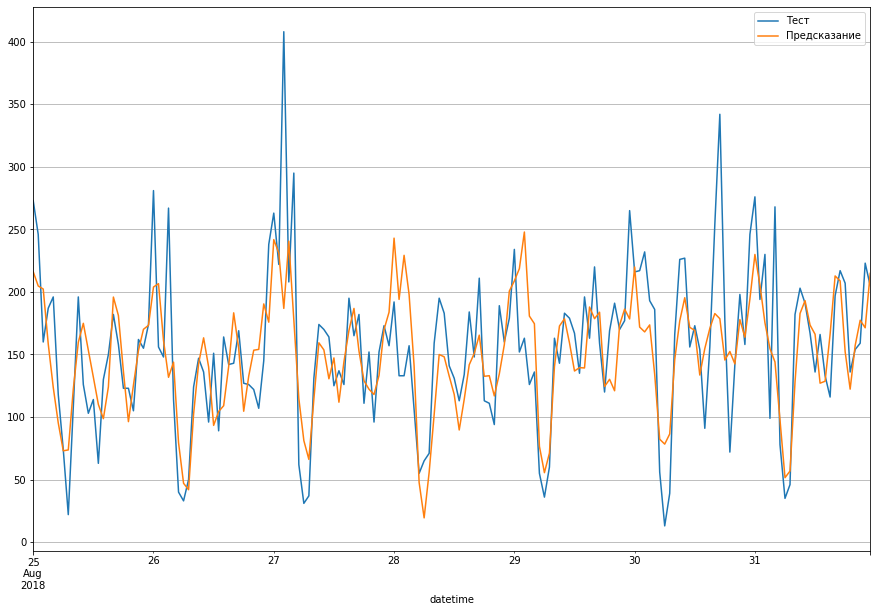

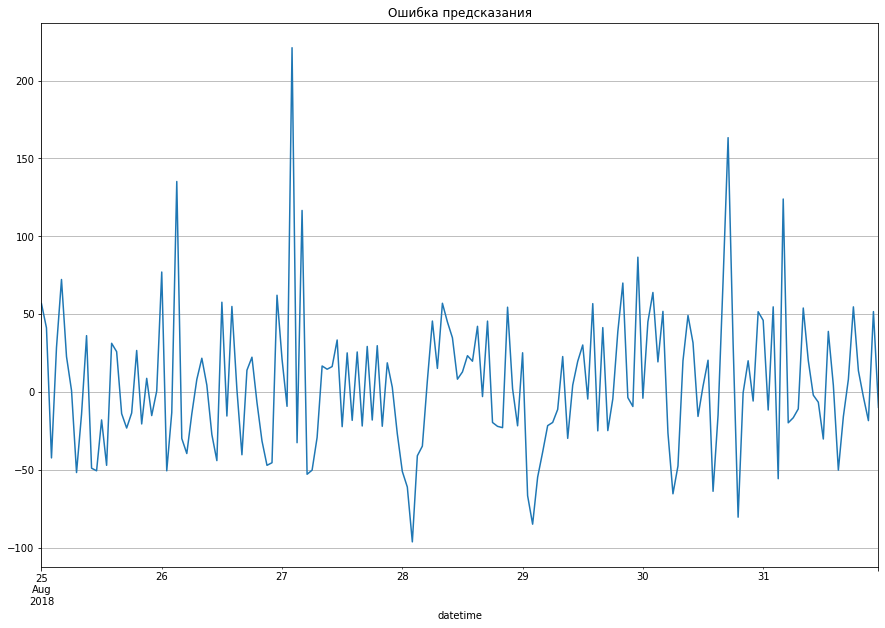

In [43]:
## тестироване линейной модели

model_lin = LinearRegression()
model_lin.fit(train_feature, train_target)
test_lin_preditions = model_lin.predict(test_feature)
print(LinearRegression.__name__)
rmse = mean_squared_error(test_target, test_lin_preditions, squared=False)

print(f'rmse на тестовой выборке {rmse}')

test_target[-7*24:].plot(label='Тест', figsize=(15,10))
pd.Series(test_preditions, index =test_target.index)[-7*24:].plot(label='Предсказание')

plt.grid()
plt.legend()
plt.show();

ttt = test_target-test_lin_preditions
ttt[-7*24:].plot(figsize=(15,10))
plt.title('Ошибка предсказания')
plt.grid()
plt.show();

LGBMRegressor
rmse на тестовой выборке 40.05756201822085


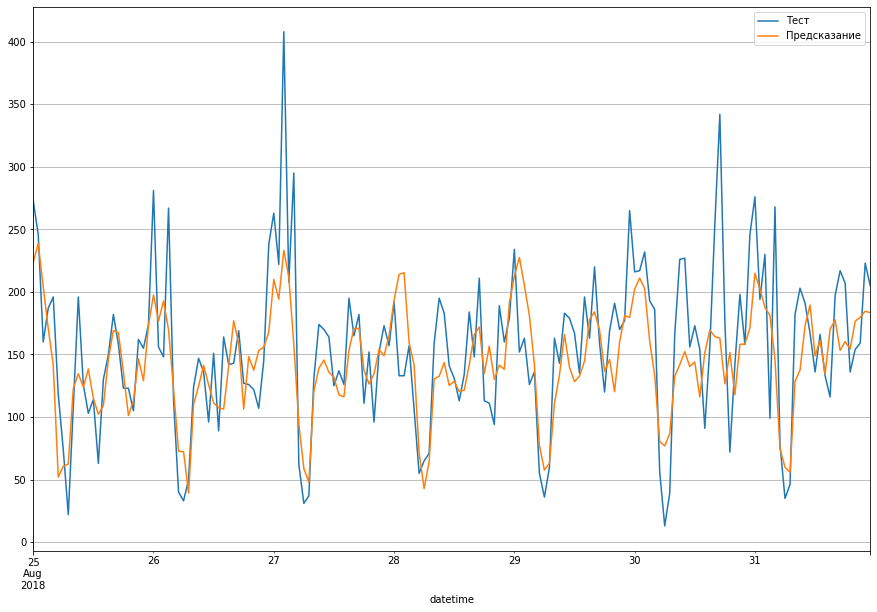

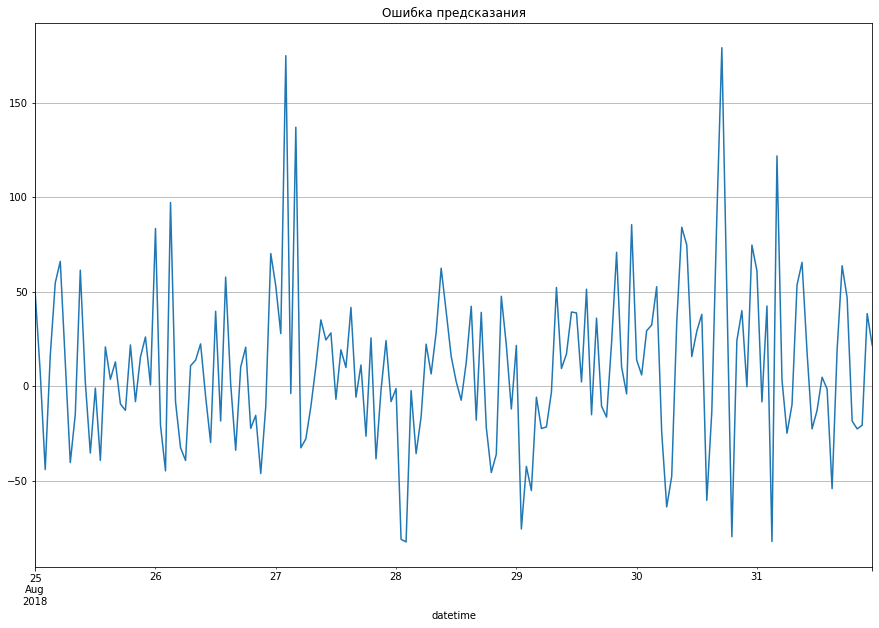

In [45]:
# %%script echo
model = LGBMRegressor(max_depth=9, n_estimators=90, random_state=150782)
model.fit(train_feature, train_target)
test_preditions = model.predict(test_feature)
print(LGBMRegressor.__name__)
rmse = mean_squared_error(test_target, test_preditions, squared=False)

print(f'rmse на тестовой выборке {rmse}')
test_target[-7*24:].plot(label='Тест', figsize=(15,10))
pd.Series(test_preditions, index =test_target.index)[-7*24:].plot(label='Предсказание')

plt.grid()
plt.legend()
plt.show();


ttt = test_target-test_preditions
ttt[-7*24:].plot(figsize=(15,10))
plt.title('Ошибка предсказания')
plt.grid()
plt.show();

## Вывод

В рамках данного исследования мы провели обучение модели предсказания количества заказов втечении часа

для построения модели было проведено
1. Семплирование данных по 1 часу
2. Анализи сезонности и тренда: тренд на повышение, сезонность равна недели
3. Генерация признаков на с учетом сезонности: среднее за последние 2 недели, данный по часам за последние 2 дня
4. Предварительный анализ работы моделей с параметрами по умолчанию (LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor,CatBoostRegressor,LGBMRegressor) - для дальнейшего исследования была выбраны LinearRegression и LGBMRegressor (самая быстрая модель основанная на деревьях и 2ая по точности)
5. Поиск лучших гипер-параметров для LGBMRegressor показания модели на кросс-валиадции
    LGBMRegressor
    best score -24.20116941084415
    best estimator params <bound method LGBMModel.get_params of LGBMRegressor(max_depth=9, n_estimators=90, random_state=150782)>
    best estimator params {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 90}
6. Проведено тестирование оторбанных моделей:
 * LinearRegression - rmse на тесте 41.95
 * LGBMRegressor - rmse на тесте 40.05
 
 
Рекомендую использовать модель LGBMRegressor совестно с описанной в исследовании процессом генерации признаков временного ряда
